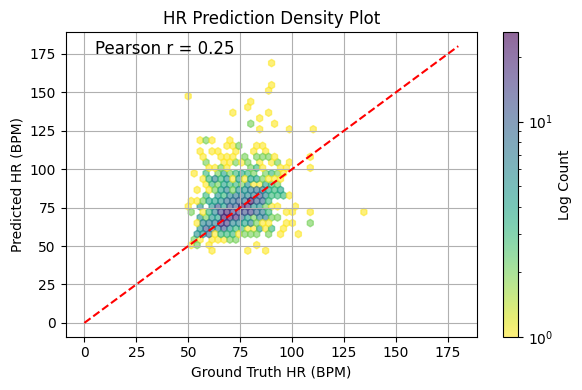

In [3]:
import matplotlib.pyplot as plt
import re
from scipy.stats import pearsonr

# === 1. 读取 inference_log.txt 文件 ===
log_path = '/home/siming/physformer/Inference_Physformer/inference_log.txt'
with open(log_path, 'r') as f:
    lines = f.readlines()

# === 2. 提取 HR 和 GT 数值 ===
pred_HR = []
gt_HR = []

for line in lines:
    match = re.search(r'HR:\s*([\d.]+)\s*\|\s*GT:\s*([\d.]+)', line)
    if match:
        pred = float(match.group(1))
        gt = float(match.group(2))
        # 同时筛掉异常小的 GT 和 pred
        if gt >= 45 and pred >= 45:
            pred_HR.append(pred)
            gt_HR.append(gt)

# === 3. 画彩色 hexbin 图 ===
plt.figure(figsize=(6, 4))
# 使用 'viridis' 颜色映射，彩色
hb = plt.hexbin(gt_HR, pred_HR, gridsize=30, cmap='viridis_r', bins='log',alpha=0.6)
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # 理想线
plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot")
plt.colorbar(hb, label="Log Count")

# === 4. Pearson 相关系数 ===
r, _ = pearsonr(gt_HR, pred_HR)
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()


[INFO] MAE: 11.10 BPM


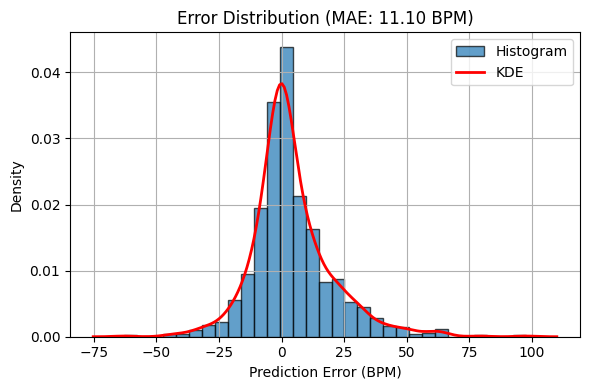

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

log_path = '/home/siming/physformer/Inference_Physformer/inference_log.txt'
with open(log_path, 'r') as f:
    lines = f.readlines()

pred_HR = []
gt_HR = []

for line in lines:
    match = re.search(r'HR:\s*([\d.]+)\s*\|\s*GT:\s*([\d.]+)', line)
    if match:
        pred = float(match.group(1))
        gt = float(match.group(2))
        if gt >= 45 and pred >= 45:  # 筛掉异常小的 GT
            pred_HR.append(pred)
            gt_HR.append(gt)

errors = np.array(pred_HR) - np.array(gt_HR)
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
#plt.xlim(-50, 50)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


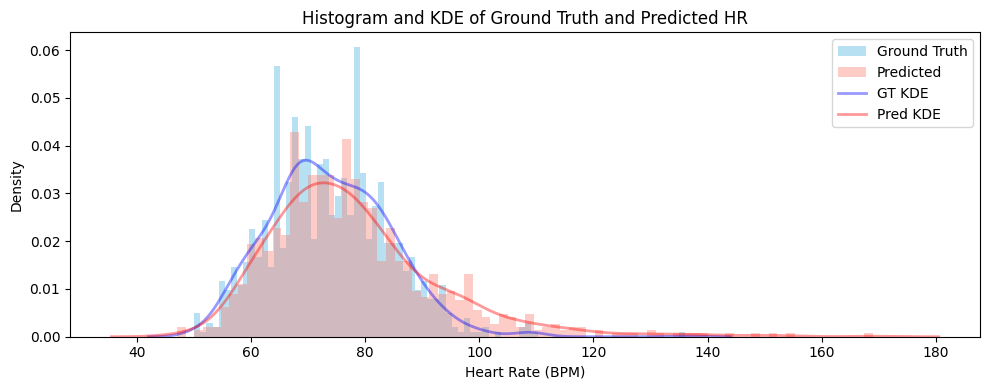

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
plt.hist(gt_HR, bins=80, alpha=0.6, label='Ground Truth', color='skyblue', density=True)
plt.hist(pred_HR, bins=80, alpha=0.4, label='Predicted', color='salmon', density=True)
sns.kdeplot(gt_HR, color='blue', linewidth=2, label='GT KDE',alpha=0.4)
sns.kdeplot(pred_HR, color='red', linewidth=2, label='Pred KDE',alpha=0.4)
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Density')
plt.title('Histogram and KDE of Ground Truth and Predicted HR')
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
# import numpy as np
# from scipy.stats import pearsonr


# # MAE
# mae = np.mean(np.abs(gt_HR - pred_HR))

# # RMSE
# rmse = np.sqrt(np.mean((gt_HR - pred_HR) ** 2))

# # Pearson Correlation
# r, _ = pearsonr(gt_HR, pred_HR)

# # Bias (mean error)
# bias = np.mean(pred_HR - gt_HR)

# # Print
# print(f"MAE: {mae:.2f} BPM")
# print(f"RMSE: {rmse:.2f} BPM")
# print(f"Bias: {bias:.2f} BPM")
# print(f"Pearson r: {r:.2f}")


                                           file_name  pred_HR  gt_HR
0  959-20230426212426785_tmp_9ccc62b1c0a18b14c809...     90.0   70.0
1  960-20230429085552277_tmp_2a736f45b9eebe4bb981...     59.5   72.0
2  961-20230430105934489_tmp_4c82a31346fa76a44676...     77.0   80.0
3  962-20230503154237807_tmp_33d1a2a4f5af8f20dccd...     72.0   81.0
4  963-20230506065854701_tmp_a61b26ec2446c9718217...     71.0   85.0


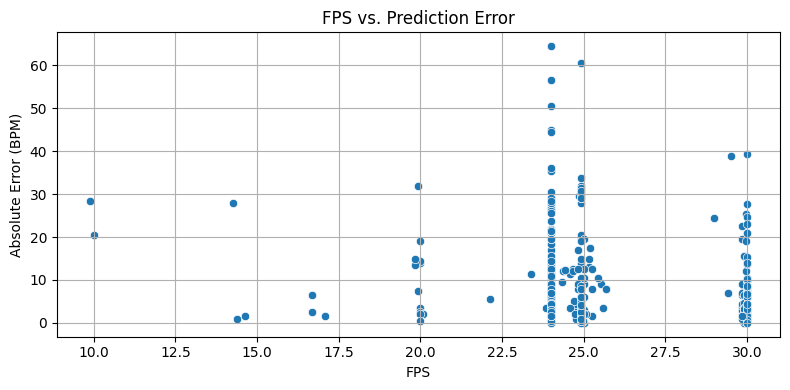

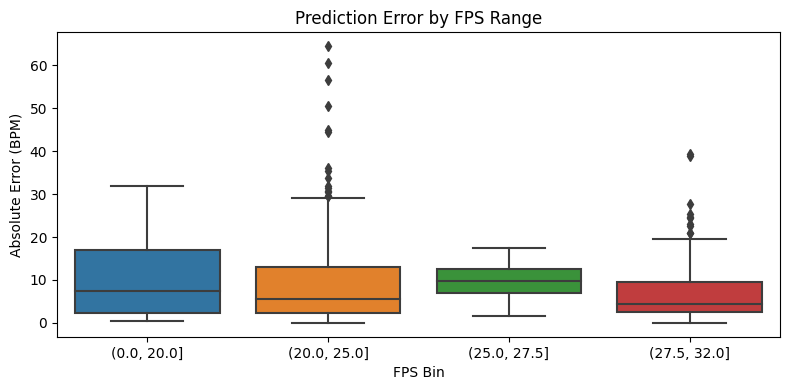

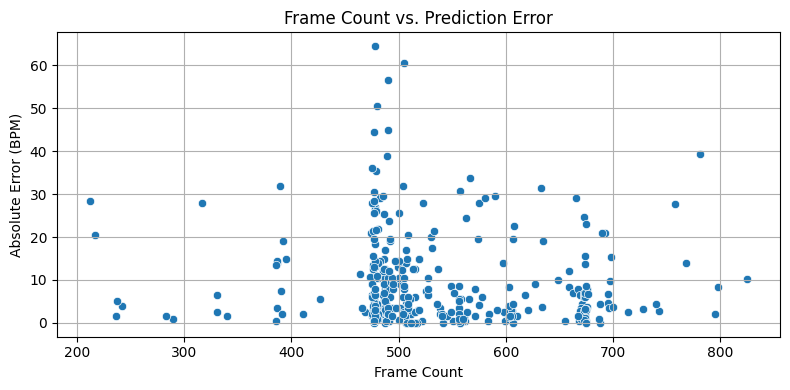

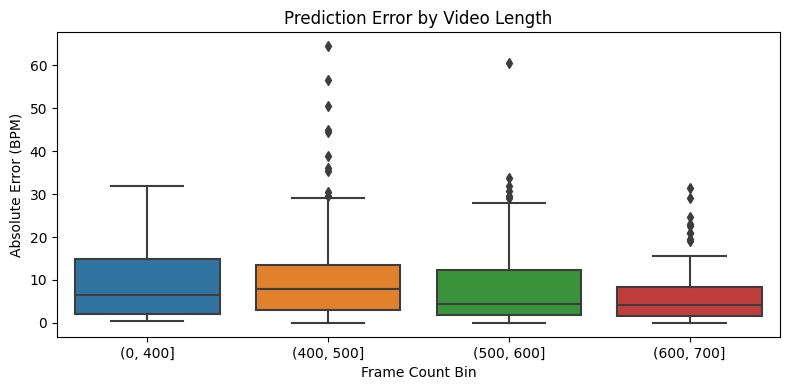

In [79]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

log_path = '/home/siming/physformer/Inference_Physformer/inference_log.txt'
file_names, pred_HR, gt_HR = [], [], []
current_file = None

with open(log_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    # 1. 获取文件名
    match_file = re.search(r'Finished processing\s+(.+?\.mp4)', line)
    if match_file:
        current_file = match_file.group(1).strip()
        continue

    # 2. 获取 HR 和 GT
    match_hr = re.search(r'HR:\s*([\d.]+)\s*\|\s*GT:\s*([\d.]+)', line)
    if match_hr and current_file:
        pred = float(match_hr.group(1))
        gt = float(match_hr.group(2))
        if pred >= 45 and gt >= 45:  # 过滤异常值
            file_names.append(current_file)
            pred_HR.append(pred)
            gt_HR.append(gt)

# === 构建 df ===
df = pd.DataFrame({
    "file_name": file_names,
    "pred_HR": pred_HR,
    "gt_HR": gt_HR
})
print(df.head())

# === 读取 sample_info 并合并 ===
sample_info_path = '/home/siming/physformer/sample_info.csv'
sample_info = pd.read_csv(sample_info_path)

# 清理文件名格式
sample_info["file_name"] = sample_info["file_name"].astype(str).str.strip()
sample_info["file_name"] = sample_info["file_name"].apply(lambda x: x if x.endswith(".mp4") else x + ".mp4")
df["file_name"] = df["file_name"].astype(str).str.strip()

# 合并
df_merged = df.merge(
    sample_info[["file_name", "fps", "frame_cnt"]],
    on="file_name",
    how="left"
)

# 计算绝对误差
df_merged["abs_error"] = abs(df_merged["pred_HR"] - df_merged["gt_HR"])

# === FPS vs Error ===
plt.figure(figsize=(8, 4))
sns.scatterplot(x="fps", y="abs_error", data=df_merged)
plt.xlabel("FPS")
plt.ylabel("Absolute Error (BPM)")
plt.title("FPS vs. Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# FPS 分箱
df_merged["fps_bin"] = pd.cut(df_merged["fps"], bins=[0, 20, 25, 27.5, 32], right=True)
plt.figure(figsize=(8, 4))
sns.boxplot(x="fps_bin", y="abs_error", data=df_merged)
plt.xlabel("FPS Bin")
plt.ylabel("Absolute Error (BPM)")
plt.title("Prediction Error by FPS Range")
plt.tight_layout()
plt.show()

# === Frame Count vs Error ===
plt.figure(figsize=(8, 4))
sns.scatterplot(x="frame_cnt", y="abs_error", data=df_merged)
plt.xlabel("Frame Count")
plt.ylabel("Absolute Error (BPM)")
plt.title("Frame Count vs. Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Frame count 分箱
df_merged["frame_bin"] = pd.cut(df_merged["frame_cnt"], bins=[0, 400, 500, 600, 700], right=True)
plt.figure(figsize=(8, 4))
sns.boxplot(x="frame_bin", y="abs_error", data=df_merged)
plt.xlabel("Frame Count Bin")
plt.ylabel("Absolute Error (BPM)")
plt.title("Prediction Error by Video Length")
plt.tight_layout()
plt.show()


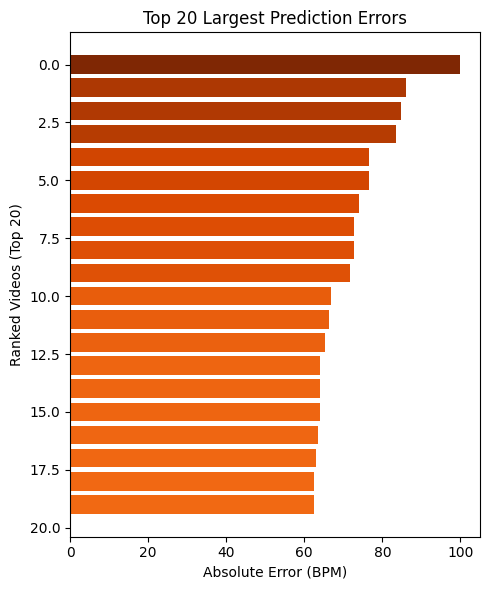

In [47]:
import numpy as np
import pandas as pd

# 示例数据
gt = np.array(df['gt_HR'])          # Ground Truth HR
pred = np.array(df['pred_HR'])        # Predicted HR
video_ids = np.array(df['file_name'])   # 对应的视频编号或路径名

# 计算误差
errors = np.abs(pred - gt)

# 排序找出 Top-N 最大误差
N = 20 # gt.size #500
top_idx = np.argsort(errors)[-N:][::-1]  # 倒序，最大的在前面

# 提取信息
top_df = pd.DataFrame({
    'Video ID': video_ids[top_idx],
    'Ground Truth HR': gt[top_idx],
    'Predicted HR': pred[top_idx],
    'Absolute Error': errors[top_idx]
})

# 输出到csv里
top_df.to_csv('/home/siming/physformer/Physformer_Run/top_'+str(N)+'_errors.csv', index=False)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.barh(top_df['Video ID'], top_df['Absolute Error'], color='tomato')
# plt.xlabel("Absolute Error (BPM)")
# plt.title(f"Top {N} Largest Prediction Errors")
# plt.gca().invert_yaxis()
# plt.gca().get_yaxis().set_visible(False)  # 不显示y轴
# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有 top_df 这个 dataframe
top_n = N
errors = top_df["Absolute Error"].values
video_ids = top_df["Video ID"].values

plt.figure(figsize=(5,6))  # 增高，更清楚
bars = plt.barh(range(top_n), errors, color=plt.cm.Oranges(errors / errors.max()))

# 加编号在左边（如 1, 2, ..., 200）
#plt.yticks(ticks=np.arange(top_n), labels=[f"{i+1}" for i in range(top_n)], fontsize=7)
plt.xlabel("Absolute Error (BPM)")
plt.ylabel("Ranked Videos (Top "+str(top_n)+")")
plt.title("Top "+str(top_n)+" Largest Prediction Errors")

plt.gca().invert_yaxis()  # 误差最大在最上面
plt.tight_layout()
plt.show()



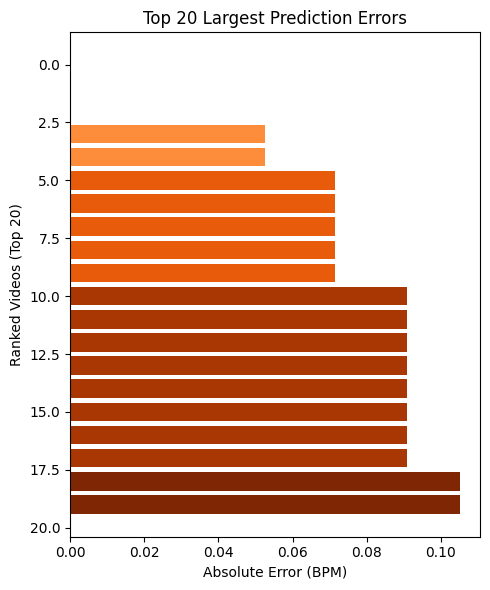

In [26]:
import numpy as np
import pandas as pd

# 示例数据
gt = np.array(df['gt_HR'])          # Ground Truth HR
pred = np.array(df['pred_HR'])        # Predicted HR
video_ids = np.array(df['file_name'])   # 对应的视频编号或路径名

# 计算误差
errors = np.abs(pred - gt)

# 排序找出 Top-N 最大误差
N = 20 # gt.size #500
bottom_idx = np.argsort(errors)[:N]  # 倒序，最大的在前面

# 提取信息
top_df = pd.DataFrame({
    'Video ID': video_ids[bottom_idx],
    'Ground Truth HR': gt[bottom_idx],
    'Predicted HR': pred[bottom_idx],
    'Absolute Error': errors[bottom_idx]
})

# 输出到csv里
top_df.to_csv('/home/siming/physformer/Physformer_Run/bottom_'+str(N)+'_errors.csv', index=False)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.barh(top_df['Video ID'], top_df['Absolute Error'], color='tomato')
# plt.xlabel("Absolute Error (BPM)")
# plt.title(f"Top {N} Largest Prediction Errors")
# plt.gca().invert_yaxis()
# plt.gca().get_yaxis().set_visible(False)  # 不显示y轴
# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有 top_df 这个 dataframe
top_n = N
errors = top_df["Absolute Error"].values
video_ids = top_df["Video ID"].values

plt.figure(figsize=(5,6))  # 增高，更清楚
bars = plt.barh(range(top_n), errors, color=plt.cm.Oranges(errors / errors.max()))

# 加编号在左边（如 1, 2, ..., 200）
#plt.yticks(ticks=np.arange(top_n), labels=[f"{i+1}" for i in range(top_n)], fontsize=7)
plt.xlabel("Absolute Error (BPM)")
plt.ylabel("Ranked Videos (Top "+str(top_n)+")")
plt.title("Top "+str(top_n)+" Largest Prediction Errors")

plt.gca().invert_yaxis()  # 误差最大在最上面
plt.tight_layout()
plt.show()



In [10]:
import numpy as np
import pandas as pd

# 假设 gt 和 pred 是 numpy array
gt = np.array(df['gt_HR'])
pred = np.array(df['pred_HR'])

# Ground Truth 分布
gt_unique, gt_counts = np.unique(gt, return_counts=True)
gt_df = pd.DataFrame({'HR': gt_unique, 'Count': gt_counts}).sort_values(by='Count', ascending=False)

# Prediction 分布
pred_unique, pred_counts = np.unique(pred, return_counts=True)
pred_df = pd.DataFrame({'HR': pred_unique, 'Count': pred_counts}).sort_values(by='Count', ascending=False)

# 输出 top 10 出现次数最多的 HR
print("🎯 Ground Truth - Top 10 Most Frequent HR:")
print(gt_df.head(10))

print("\n🎯 Predicted HR - Top 10 Most Frequent HR:")
print(pred_df.head(10))


🎯 Ground Truth - Top 10 Most Frequent HR:
      HR  Count
23  70.0     67
21  68.0     60
18  65.0     55
22  69.0     47
25  72.0     44
26  73.0     43
20  67.0     42
29  76.0     39
33  80.0     38
36  83.0     38

🎯 Predicted HR - Top 10 Most Frequent HR:
           HR  Count
57  90.000000     82
45  79.090909     67
52  84.545455     65
42  76.363636     63
49  81.818182     63
7   35.454545     50
35  70.909091     45
38  73.636364     44
31  68.181818     40
39  73.928571     37


                                           file_name    pred_HR  gt_HR
0  959-20230426212426785_tmp_9ccc62b1c0a18b14c809...  70.714286   73.0
1  960-20230429085552277_tmp_2a736f45b9eebe4bb981...  80.357143   70.0
2  961-20230430105934489_tmp_4c82a31346fa76a44676...  61.071429   72.0
3  962-20230503154237807_tmp_33d1a2a4f5af8f20dccd...  77.142857   80.0
4  963-20230506065854701_tmp_a61b26ec2446c9718217...  70.714286   81.0
[INFO] Columns: ['file_name', 'pred_HR', 'gt_HR']


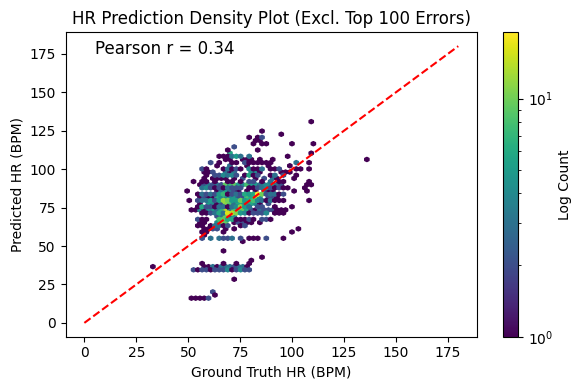

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === 1. 读取 CSV ===
df = pd.read_csv('/home/siming/physformer/Physformer_Run_7.17/HR_results.csv')
sample_info = pd.read_csv('/home/siming/physformer/sample_info.csv')

print(df.head())
print("[INFO] Columns:", df.columns.tolist())

# === 2. 计算误差并剔除 Top 100 最大误差样本 ===
df['abs_error'] = (df['gt_HR'] - df['pred_HR']).abs()
df_filtered = df.sort_values('abs_error', ascending=False).iloc[100:]  # 去掉前100个误差最大的

# === 3. 画 hexbin 散点密度图 ===
plt.figure(figsize=(6, 4))
plt.hexbin(df_filtered['gt_HR'], df_filtered['pred_HR'], gridsize=50, cmap='viridis', bins='log')
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # 理想线

plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot (Excl. Top 100 Errors)")
plt.colorbar(label="Log Count")

# === 4. 加入 Pearson 相关系数 ===
r, _ = pearsonr(df_filtered['gt_HR'], df_filtered['pred_HR'])
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')

plt.tight_layout()
plt.show()


[INFO] MAE: 12.94 BPM


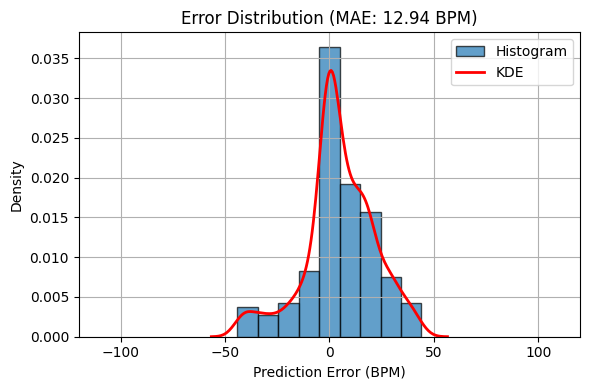

In [50]:
import numpy as np
import seaborn as sns

errors = df_filtered['pred_HR'] - df_filtered['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=9, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
plt.xlim(-120, 120)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 连续fft

In [27]:
import re
import pandas as pd

def extract_hr_data(log_text):
    pattern = re.compile(
        r"\[INFO\] Finished ([\w\-.]+\.mp4).+?: Pred HR = ([\d.]+) \| GT HR = ([\d.]+)"
    )
    matches = pattern.findall(log_text)
    df = pd.DataFrame(matches, columns=["video_name", "pred_HR", "gt_HR"])
    df["pred_HR"] = df["pred_HR"].astype(float)
    df["gt_HR"] = df["gt_HR"].astype(float)
    return df

# 读取旧版本（视频数量少）
with open("/home/siming/physformer/Physformer_Run/inference_log.txt", "r") as f:
    log_old = f.read()
df_old = extract_hr_data(log_old)
df_old = df_old.rename(columns={"pred_HR": "old_pred_HR", "gt_HR": "gt_HR"})

# 读取新版本（Physformer_Run_7.17）
with open("/home/siming/physformer/Physformer_Run_7.17/inference_log.txt", "r") as f:
    log_new = f.read()
df_new = extract_hr_data(log_new)
df_new = df_new.rename(columns={"pred_HR": "new_pred_HR", "gt_HR": "gt_HR_new"})

# 合并两个版本（以旧版的视频为主）
df_merged = pd.merge(df_old, df_new, on="video_name", how="left")

# 检查 GT 是否一致
gt_diff = (df_merged["gt_HR"] - df_merged["gt_HR_new"]).abs()
if gt_diff.max() > 1e-2:
    print("⚠️ Warning: GT HR mismatch between versions!")
df_merged = df_merged.drop(columns=["gt_HR_new"])

print("df_merged 行数:", len(df_merged))



df_merged 行数: 159


[INFO] MAE: 14.51 BPM


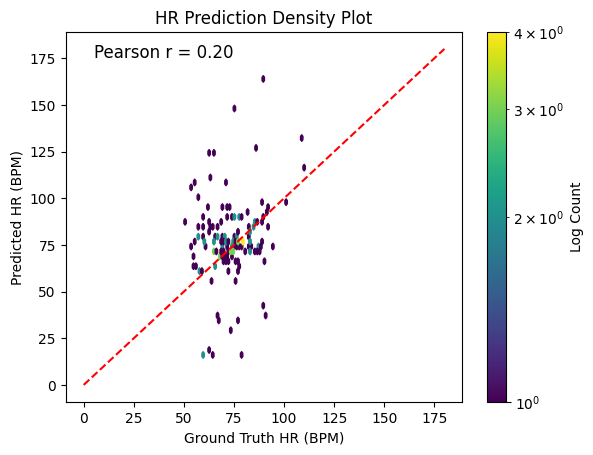

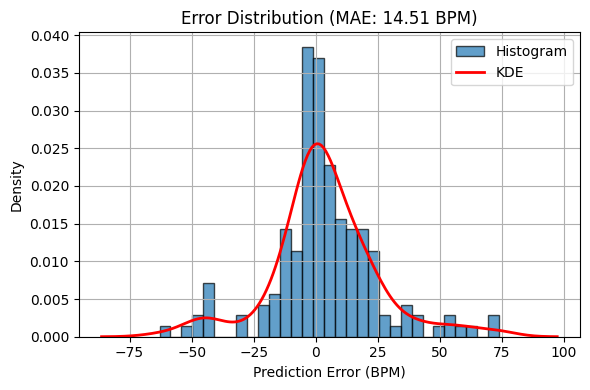

In [28]:
plt.hexbin(df_merged['gt_HR'], df_merged['new_pred_HR'], gridsize=50, cmap='viridis', bins='log')
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # 理想线
plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot")
plt.colorbar(label="Log Count")

from scipy.stats import pearsonr
r, _ = pearsonr(df_merged['gt_HR'], df_merged['new_pred_HR'])
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')


import numpy as np
import seaborn as sns

errors = df_merged['new_pred_HR'] - df_merged['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
#plt.xlim(-50, 50)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[INFO] MAE: 14.46 BPM


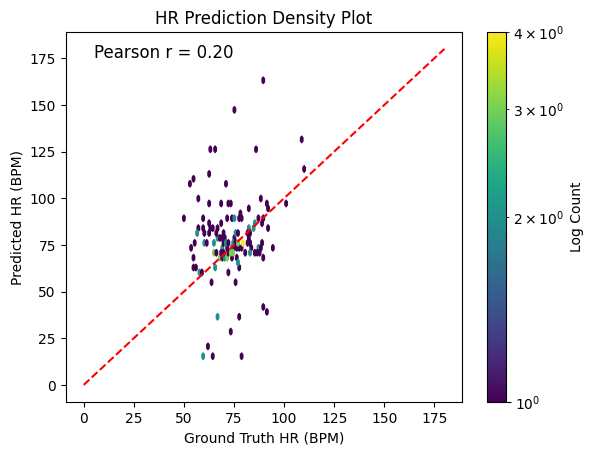

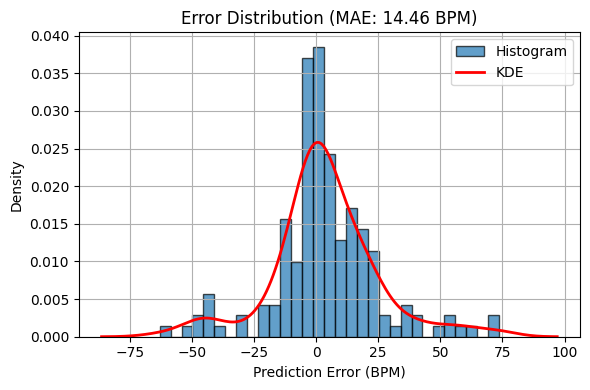

In [29]:
plt.hexbin(df_merged['gt_HR'], df_merged['old_pred_HR'], gridsize=50, cmap='viridis', bins='log')
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # 理想线
plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot")
plt.colorbar(label="Log Count")

from scipy.stats import pearsonr
r, _ = pearsonr(df_merged['gt_HR'], df_merged['old_pred_HR'])
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')


import numpy as np
import seaborn as sns

errors = df_merged['old_pred_HR'] - df_merged['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
#plt.xlim(-50, 50)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
